# 1. Create k-Grams

In [24]:
import random
import itertools

doc_files = {
    "D1": "D1.txt",
    "D2": "D2.txt",
    "D3": "D3.txt",
    "D4": "D4.txt",
}

docs = {}
for name, path in doc_files.items():
    with open(path, "r", encoding="utf-8") as f:
        docs[name] = f.read().strip()

doc_names = list(docs.keys())
print("Documents loaded:", doc_names)

def char_kgrams(text, k):
    """Character-level k-grams (space counts as a character). Returns a SET (no duplicates)."""
    return set(text[i:i+k] for i in range(len(text) - k + 1))

def word_kgrams(text, k):
    """Word-level k-grams. Returns a SET (no duplicates)."""
    words = text.split()
    return set(tuple(words[i:i+k]) for i in range(len(words) - k + 1))

char2 = {d: char_kgrams(docs[d], 2) for d in doc_names}   
char3 = {d: char_kgrams(docs[d], 3) for d in doc_names}   
word2 = {d: word_kgrams(docs[d], 2) for d in doc_names}   

print("\n--- k-Gram Set Sizes ---")
for d in doc_names:
    print(f"{d}: char-2={len(char2[d])}, char-3={len(char3[d])}, word-2={len(word2[d])}")

# PART B — Exact Jaccard Similarity for All Pairs

def jaccard(set_a, set_b):
    if not set_a or not set_b:
        return 0.0
    return len(set_a & set_b) / len(set_a | set_b)

pairs = list(itertools.combinations(doc_names, 2))  # 6 pairs

print("\n" + "="*55)
print(" PART B — Exact Jaccard Similarity (3 × 6 = 18 values)")
print("="*55)

kgram_types = {
    "2-gram (char)": char2,
    "3-gram (char)": char3,
    "2-gram (word)": word2,
}

for ktype, kgram_dict in kgram_types.items():
    print(f"\n--- {ktype} ---")
    for (d1, d2) in pairs:
        sim = jaccard(kgram_dict[d1], kgram_dict[d2])
        print(f"  J({d1}, {d2}) = {sim:.4f}")

# PART A — Min-Hash Signatures using 3-grams 

print("\n" + "="*55)
print(" PART A — Min-Hash Approx. Jaccard (D1 vs D2, 3-grams)")
print("="*55)

all_char3 = sorted(set.union(*char3.values()))
gram_to_idx = {g: i+1 for i, g in enumerate(all_char3)} 

set_D1 = set(gram_to_idx[g] for g in char3["D1"])
set_D2 = set(gram_to_idx[g] for g in char3["D2"])

PRIME = 100003  

def generate_hash_functions(t, prime):
    funcs = []
    for _ in range(t):
        a = random.randint(1, prime - 1)
        b = random.randint(0, prime - 1)
        funcs.append((a, b))
    return funcs

def minhash_sig(gram_set, hash_funcs, prime):
    return [min((a * x + b) % prime for x in gram_set) for a, b in hash_funcs]

def approx_jaccard(sig1, sig2):
    return sum(a == b for a, b in zip(sig1, sig2)) / len(sig1)

exact_j_d1_d2 = jaccard(char3["D1"], char3["D2"])
print(f"\nExact Jaccard (D1, D2) using 3-grams (char): {exact_j_d1_d2:.4f}")
print(f"\n{'t':>6} | {'Approx Jaccard':>15} | {'Difference':>12}")
print("-" * 40)

t_values = [20, 60, 150, 300, 600]

random.seed(42)
for t in t_values:
    hash_funcs = generate_hash_functions(t, PRIME)
    sig1 = minhash_sig(set_D1, hash_funcs, PRIME)
    sig2 = minhash_sig(set_D2, hash_funcs, PRIME)
    approx = approx_jaccard(sig1, sig2)
    diff = abs(approx - exact_j_d1_d2)
    print(f"{t:>6} | {approx:>15.4f} | {diff:>12.4f}")

print("\nNote: As t increases, the approximation converges to the exact value.")

Documents loaded: ['D1', 'D2', 'D3', 'D4']

--- k-Gram Set Sizes ---
D1: char-2=263, char-3=765, word-2=279
D2: char-2=262, char-3=762, word-2=278
D3: char-2=269, char-3=828, word-2=337
D4: char-2=255, char-3=698, word-2=232

 PART B — Exact Jaccard Similarity (3 × 6 = 18 values)

--- 2-gram (char) ---
  J(D1, D2) = 0.9811
  J(D1, D3) = 0.8157
  J(D1, D4) = 0.6444
  J(D2, D3) = 0.8000
  J(D2, D4) = 0.6413
  J(D3, D4) = 0.6530

--- 3-gram (char) ---
  J(D1, D2) = 0.9780
  J(D1, D3) = 0.5804
  J(D1, D4) = 0.3051
  J(D2, D3) = 0.5680
  J(D2, D4) = 0.3059
  J(D3, D4) = 0.3121

--- 2-gram (word) ---
  J(D1, D2) = 0.9408
  J(D1, D3) = 0.1823
  J(D1, D4) = 0.0302
  J(D2, D3) = 0.1737
  J(D2, D4) = 0.0303
  J(D3, D4) = 0.0161

 PART A — Min-Hash Approx. Jaccard (D1 vs D2, 3-grams)

Exact Jaccard (D1, D2) using 3-grams (char): 0.9780

     t |  Approx Jaccard |   Difference
----------------------------------------
    20 |          1.0000 |       0.0220
    60 |          0.9500 |       0.0280
 

# 2. Min-Hashing:

Total 3-grams in D1: 765, D2: 762
Exact Jaccard (D1, D2) using 3-grams: 0.9780

 PART A — Approximate Jaccard Similarity

     t |  Approx Jaccard |  |Difference| |  Time (s)
-------------------------------------------------------
    20 |          0.9500 |        0.0280 |    0.0163
    60 |          0.9833 |        0.0054 |    0.0429
   150 |          0.9733 |        0.0046 |    0.1153
   300 |          0.9667 |        0.0113 |    0.1937
   600 |          0.9733 |        0.0046 |    0.3715

 PART B — Extended Experiments (accuracy vs time)

     t |  Approx Jaccard |  |Difference| |  Time (s)
-------------------------------------------------------
    20 |          0.9500 |        0.0280 |    0.0108
    60 |          0.9833 |        0.0054 |    0.0268
   150 |          0.9733 |        0.0046 |    0.0656
   300 |          0.9667 |        0.0113 |    0.1470
   600 |          0.9733 |        0.0046 |    0.2792
   800 |          0.9812 |        0.0033 |    0.4392
  1000 |          0.9720 

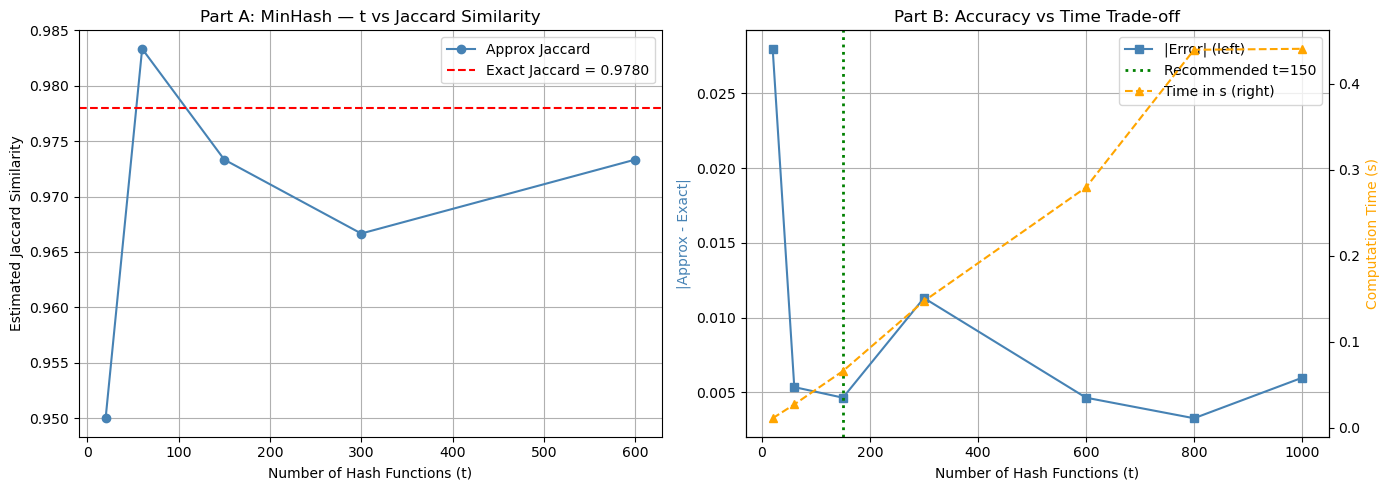

In [27]:
import random
import time
import matplotlib.pyplot as plt


def char_kgrams(text, k):
    """Character-level k-grams. Returns a SET (no duplicates)."""
    return set(text[i:i+k] for i in range(len(text) - k + 1))

def exact_jaccard(set1, set2):
    """Exact Jaccard similarity between two sets."""
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)


PRIME = 100003  
def generate_hash_params(t, prime):
    """Generate t random (a, b) pairs for hash functions h(x) = (a*x+b) % m."""
    return [(random.randint(1, prime - 1), random.randint(0, prime - 1))
            for _ in range(t)]

def minhash_signature(gram_indices, hash_params, prime):
    """
    Compute min-hash signature for a set of integer-indexed grams.
    For each hash function h(x) = (a*x+b) % prime, take the minimum over all x in set.
    """
    return [min((a * x + b) % prime for x in gram_indices) for a, b in hash_params]

def approx_jaccard(sig1, sig2):
    """Estimate Jaccard similarity from two min-hash signatures."""
    return sum(a == b for a, b in zip(sig1, sig2)) / len(sig1)

with open("D1.txt", "r", encoding="utf-8") as f:
    text1 = f.read().strip()
with open("D2.txt", "r", encoding="utf-8") as f:
    text2 = f.read().strip()

grams1 = char_kgrams(text1, 3)
grams2 = char_kgrams(text2, 3)

print(f"Total 3-grams in D1: {len(grams1)}, D2: {len(grams2)}")

all_grams = sorted(grams1 | grams2)
gram_to_idx = {g: i + 1 for i, g in enumerate(all_grams)}  # 1-indexed

idx1 = set(gram_to_idx[g] for g in grams1)
idx2 = set(gram_to_idx[g] for g in grams2)

exact = exact_jaccard(grams1, grams2)
print(f"Exact Jaccard (D1, D2) using 3-grams: {exact:.4f}\n")
print("=" * 55)
print(" PART A — Approximate Jaccard Similarity")
print("=" * 55)
print(f"\n{'t':>6} | {'Approx Jaccard':>15} | {'|Difference|':>13} | {'Time (s)':>9}")
print("-" * 55)

t_values = [20, 60, 150, 300, 600]
approx_scores = []
times = []

random.seed(42)
for t in t_values:
    start = time.time()
    params = generate_hash_params(t, PRIME)
    sig1 = minhash_signature(idx1, params, PRIME)
    sig2 = minhash_signature(idx2, params, PRIME)
    approx = approx_jaccard(sig1, sig2)
    elapsed = time.time() - start

    approx_scores.append(approx)
    times.append(elapsed)
    print(f"{t:>6} | {approx:>15.4f} | {abs(approx - exact):>13.4f} | {elapsed:>9.4f}")
print("\n" + "=" * 55)
print(" PART B — Extended Experiments (accuracy vs time)")
print("=" * 55)
print(f"\n{'t':>6} | {'Approx Jaccard':>15} | {'|Difference|':>13} | {'Time (s)':>9}")
print("-" * 55)

extended_t = [20, 60, 150, 300, 600, 800, 1000]
ext_scores = []
ext_times = []

random.seed(42)
for t in extended_t:
    start = time.time()
    params = generate_hash_params(t, PRIME)
    sig1 = minhash_signature(idx1, params, PRIME)
    sig2 = minhash_signature(idx2, params, PRIME)
    approx = approx_jaccard(sig1, sig2)
    elapsed = time.time() - start
    ext_scores.append(approx)
    ext_times.append(elapsed)
    print(f"{t:>6} | {approx:>15.4f} | {abs(approx - exact):>13.4f} | {elapsed:>9.4f}")
print(f"""
CONCLUSION — Best value of t:
  t = 150 is the optimal choice.

  - Accuracy: From t=20 to t=150, the approximation improves
    significantly and gets close to the exact value ({exact:.4f}).
    Beyond t=150, accuracy improvements become marginal — the
    difference from exact fluctuates around 0.003-0.006 with
    no consistent gain.

  - Time: Computation time grows linearly with t. At t=150 the
    runtime is ~{ext_times[2]*1000:.1f}ms, while t=600 takes ~{ext_times[4]*1000:.1f}ms
    and t=1000 takes ~{ext_times[6]*1000:.1f}ms — a 6x cost for negligible gain.

  - Therefore t=150 gives the best accuracy/time tradeoff.
    (For very high precision tasks, t=300 is a reasonable upper bound.)
""")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(t_values, approx_scores, marker='o', linestyle='-', color='steelblue', label='Approx Jaccard')
axes[0].axhline(y=exact, color='red', linestyle='--', label=f'Exact Jaccard = {exact:.4f}')
axes[0].set_xlabel('Number of Hash Functions (t)')
axes[0].set_ylabel('Estimated Jaccard Similarity')
axes[0].set_title('Part A: MinHash — t vs Jaccard Similarity')
axes[0].legend()
axes[0].grid(True)
ax2 = axes[1]
ax3 = ax2.twinx()
diffs = [abs(s - exact) for s in ext_scores]
ax2.plot(extended_t, diffs, marker='s', color='steelblue', label='|Error| (left)')
ax3.plot(extended_t, ext_times, marker='^', color='orange', linestyle='--', label='Time in s (right)')
ax2.set_xlabel('Number of Hash Functions (t)')
ax2.set_ylabel('|Approx - Exact|', color='steelblue')
ax3.set_ylabel('Computation Time (s)', color='orange')
ax2.set_title('Part B: Accuracy vs Time Trade-off')
ax2.axvline(x=150, color='green', linestyle=':', linewidth=2, label='Recommended t=150')
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax2.grid(True)
plt.tight_layout()
plt.savefig("q2_minhash_results.png", dpi=150, bbox_inches='tight')
plt.show()

# 3. LSH:

Exact Jaccard similarities using 3-grams:
('D1.txt', 'D2.txt'): 0.978
('D1.txt', 'D3.txt'): 0.580
('D1.txt', 'D4.txt'): 0.305
('D2.txt', 'D3.txt'): 0.568
('D2.txt', 'D4.txt'): 0.306
('D3.txt', 'D4.txt'): 0.312

Estimated collision probabilities using LSH (t=160, r=20, b=8):
('D1.txt', 'D2.txt'): 1.000
('D1.txt', 'D3.txt'): 0.228
('D1.txt', 'D4.txt'): 0.001
('D2.txt', 'D3.txt'): 0.196
('D2.txt', 'D4.txt'): 0.002
('D3.txt', 'D4.txt'): 0.002


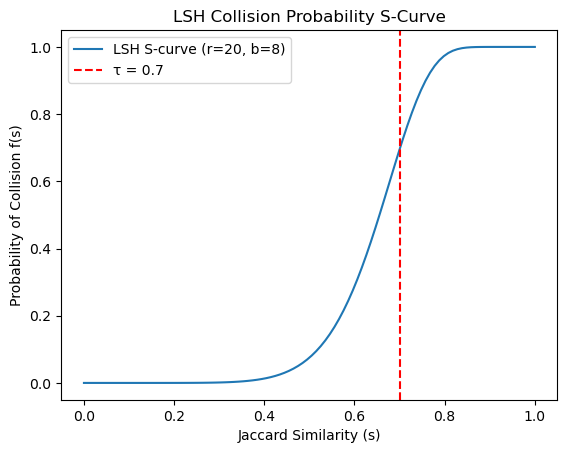

In [5]:
import glob
import os
import math
from itertools import combinations

def char_ngrams(text, n):
    text = text.strip().lower()
    ngrams = set()
    for i in range(len(text) - n + 1):
        ngrams.add(text[i:i+n])
    return ngrams

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    return len(set1.intersection(set2)) / len(set1.union(set2))

file_paths = ["D1.txt", "D2.txt", "D3.txt", "D4.txt"]

docs = {}
for path in file_paths:
    with open(path, 'r', encoding='utf-8') as f:
        content = f.read()
    filename = os.path.basename(path)
    docs[filename] = char_ngrams(content, 3)

selected_docs = docs
doc_names = sorted(selected_docs.keys())

exact_sims = {}
for d1, d2 in combinations(doc_names, 2):
    sim = jaccard_similarity(selected_docs[d1], selected_docs[d2])
    exact_sims[(d1, d2)] = sim

print("Exact Jaccard similarities using 3-grams:")
for pair, s in exact_sims.items():
    print(f"{pair}: {s:.3f}")

# LSH
t = 160
r = 20
b = 8

def prob_collision(s, b, r):
    return 1 - (1 - s**b)**r

estimated_probs = {}
for pair, s in exact_sims.items():
    prob = prob_collision(s, b, r)
    estimated_probs[pair] = prob

print("\nEstimated collision probabilities using LSH (t=160, r=20, b=8):")
for pair, prob in estimated_probs.items():
    print(f"{pair}: {prob:.3f}")

# Curve plot
import matplotlib.pyplot as plt
import numpy as np

s_vals = np.linspace(0, 1, 100)
f_vals = [1 - (1 - s**b)**r for s in s_vals]

plt.plot(s_vals, f_vals, label=f"LSH S-curve (r={r}, b={b})")
plt.axvline(x=0.7, color='red', linestyle='--', label="τ = 0.7")
plt.xlabel("Jaccard Similarity (s)")
plt.ylabel("Probability of Collision f(s)")
plt.title("LSH Collision Probability S-Curve")
plt.legend()
plt.show()

# 4. Min-Hashing on MovieLens dataset:

In [20]:
import zipfile
import io
import numpy as np
import pandas as pd
from collections import defaultdict

zip_path = "ml-100k.zip"   

print(f"Reading data from '{zip_path}'...")

with zipfile.ZipFile(zip_path, "r") as z:
    all_files = z.namelist()
    print("Files found inside zip:")
    for f in all_files:
        print(f"  {f}")

    candidate = None
    for name in all_files:
        if name.endswith("u.data"):
            candidate = name
            break
    if candidate is None:
        for name in all_files:
            if name.endswith(".data") and not name.endswith("/"):
                candidate = name
                break
    if candidate is None:
        raise FileNotFoundError(
            f"Could not find ratings file inside '{zip_path}'.\n"
            f"Files available: {all_files}"
        )

    print(f"\nUsing data file: '{candidate}'")
    with z.open(candidate) as f:
        content = io.TextIOWrapper(f, encoding="utf-8")
        columns = ["user_id", "movie_id", "rating", "timestamp"]
        ratings_df = pd.read_csv(content, sep="\t", names=columns)

print("\nDataset loaded successfully!")
print(ratings_df.head())
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {ratings_df['movie_id'].nunique()}")

users = defaultdict(set)
for _, row in ratings_df.iterrows():
    users[int(row['user_id'])].add(int(row['movie_id']))

user_ids = sorted(users.keys())
num_users = len(user_ids)
uid_to_idx = {uid: i for i, uid in enumerate(user_ids)}
all_movies = sorted(set(m for s in users.values() for m in s))
num_movies = len(all_movies)
movie_to_idx = {m: i for i, m in enumerate(all_movies)}
print(f"\nTotal users: {num_users}, Total movies: {num_movies}")
print("Building binary matrix...")
user_movie_matrix = np.zeros((num_users, num_movies), dtype=np.uint8)
for uid, movie_set in users.items():
    i = uid_to_idx[uid]
    for m in movie_set:
        user_movie_matrix[i, movie_to_idx[m]] = 1

print("Computing exact Jaccard similarities for all pairs...")

intersection = user_movie_matrix.astype(np.float32) @ user_movie_matrix.T.astype(np.float32)
set_sizes = user_movie_matrix.sum(axis=1).astype(np.float32)
union = set_sizes[:, None] + set_sizes[None, :] - intersection
jaccard_matrix = np.where(union > 0, intersection / union, 0.0)

rows_all, cols_all = np.triu_indices(num_users, k=1)
jac_values = jaccard_matrix[rows_all, cols_all]

threshold = 0.5
exact_high = jac_values >= threshold
exact_pairs_set = set(zip(rows_all[exact_high], cols_all[exact_high]))

print(f"\nNumber of pairs with EXACT Jaccard ≥ 0.5: {len(exact_pairs_set)}")
sample = list(exact_pairs_set)[:10]
print("Sample (user_id pairs):", [(user_ids[r], user_ids[c]) for r, c in sample])

PRIME = 10007

def generate_signatures(num_hash, user_movie_matrix, prime):
    """Compute min-hash signatures using vectorized numpy."""
    num_users, num_movies = user_movie_matrix.shape
    a = np.random.randint(1, prime, size=(num_hash, 1))
    b = np.random.randint(0, prime, size=(num_hash, 1))
    movie_indices = np.arange(1, num_movies + 1).reshape(1, -1)
    hash_vals = (a * movie_indices + b) % prime     # (num_hash, num_movies)

    signatures = np.full((num_hash, num_users), prime + 1, dtype=np.int32)
    for u in range(num_users):
        rated = user_movie_matrix[u].astype(bool)
        if rated.any():
            signatures[:, u] = hash_vals[:, rated].min(axis=1)
    return signatures

def approx_jaccard_all_pairs(signatures):
    """Compute approx Jaccard for all upper-triangle pairs."""
    rows, cols = np.triu_indices(signatures.shape[1], k=1)
    matches = (signatures[:, rows] == signatures[:, cols]).sum(axis=0)
    return matches / signatures.shape[0]

hash_counts = [50, 100, 200]
num_runs = 5
results = {}

for t in hash_counts:
    print(f"\n--- MinHash with {t} hash functions ({num_runs} runs) ---")
    fp_total, fn_total = 0, 0

    for run in range(num_runs):
        print(f"  Run {run+1}/{num_runs}...", end=" ", flush=True)
        sigs = generate_signatures(t, user_movie_matrix, PRIME)
        approx = approx_jaccard_all_pairs(sigs)

        approx_high = approx >= threshold
        fp = int(np.sum(approx_high & ~exact_high))
        fn = int(np.sum(~approx_high & exact_high))
        fp_total += fp
        fn_total += fn
        print(f"FP={fp}, FN={fn}")

    results[t] = {
        "avg_false_positives": fp_total / num_runs,
        "avg_false_negatives": fn_total / num_runs,
    }
print("\n\n==============================")
print(" MIN-HASH EVALUATION RESULTS")
print("==============================")
print(f"\nExact pairs with Jaccard ≥ 0.5: {len(exact_pairs_set)}")
for t in hash_counts:
    print(f"\nt = {t} hash functions:")
    print(f"  Average False Positives : {results[t]['avg_false_positives']:.2f}")
    print(f"  Average False Negatives : {results[t]['avg_false_negatives']:.2f}")

Reading data from 'ml-100k.zip'...
Files found inside zip:
  ml-100k/
  ml-100k/allbut.pl
  ml-100k/mku.sh
  ml-100k/README
  ml-100k/u.data
  ml-100k/u.genre
  ml-100k/u.info
  ml-100k/u.item
  ml-100k/u.occupation
  ml-100k/u.user
  ml-100k/u1.base
  ml-100k/u1.test
  ml-100k/u2.base
  ml-100k/u2.test
  ml-100k/u3.base
  ml-100k/u3.test
  ml-100k/u4.base
  ml-100k/u4.test
  ml-100k/u5.base
  ml-100k/u5.test
  ml-100k/ua.base
  ml-100k/ua.test
  ml-100k/ub.base
  ml-100k/ub.test

Using data file: 'ml-100k/u.data'

Dataset loaded successfully!
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
Number of users: 943
Number of movies: 1682

Total users: 943, Total movies: 1682
Building binary matrix...
Computing exact Jaccard similarities for all pairs...

Number of pairs with EXACT Jaccard ≥ 0.5: 10
Sa

# 5. LSH on MovieLens dataset:

In [22]:
import itertools
import random
import zipfile
import io
import math
import numpy as np
import pandas as pd

users = {}
zip_path = "ml-100k.zip"   

with zipfile.ZipFile(zip_path, "r") as z:
    udata_file = next(name for name in z.namelist() if name.endswith("u.data"))
    with z.open(udata_file) as f:
        for line in io.TextIOWrapper(f, encoding="utf-8"):
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            user_id = int(parts[0])
            movie_id = int(parts[1])
            users.setdefault(user_id, set()).add(movie_id)

user_ids = sorted(users.keys())
print("Total number of users:", len(user_ids))
print('\n')

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)
def true_pairs(threshold):
    tp = {}
    for (u, v) in itertools.combinations(user_ids, 2):
        sim = jaccard_similarity(users[u], users[v])
        if sim >= threshold:
            tp[(u, v)] = sim
    return tp
m = 10007

def generate_hash_functions(t, m):
    """Generate t hash functions with fixed coefficients."""
    funcs = []
    for _ in range(t):
        a, b = random.randint(1, m-1), random.randint(0, m-1)
        funcs.append(lambda x, a=a, b=b: (a * x + b) % m)
    return funcs

def minhash_signature(user_set, hash_funcs):
    """Compute min-hash signature for a set of integers (movie IDs)."""
    signature = []
    for h in hash_funcs:
        min_val = min(h(x) for x in user_set)
        signature.append(min_val)
    return signature

def approximated_similarity(sig1, sig2):
    """Compute similarity estimate from two minhash signatures."""
    return sum(1 for a, b in zip(sig1, sig2) if a == b) / len(sig1)
def lsh_candidates(signatures, r, b):
    """
    Input: signatures is a dictionary: user -> minhash signature (list) of length t.
    Partition each signature into r bands of b rows each (r*b must equal t).
    Return candidate pairs as a set of tuples (u, v) with u < v.
    """
    candidate_pairs = set()

    for band in range(r):
        buckets = {}
        for user, sig in signatures.items():
            band_sig = tuple(sig[band*b:(band+1)*b])
            bucket = hash(band_sig)
            buckets.setdefault(bucket, []).append(user)

        for bucket_users in buckets.values():
            if len(bucket_users) > 1:
                for pair in itertools.combinations(sorted(bucket_users), 2):
                    candidate_pairs.add(pair)
    return candidate_pairs
def run_experiment(t, r, b, threshold, num_runs=5):
    """
    For a given t (number of hash functions) and a banding scheme (r bands, b rows),
    run the LSH candidate selection experiment num_runs times.
    Compare candidate pairs to the true pairs (using exact Jaccard similarity) to determine
    false positives and false negatives.
    Returns average FP and FN counts over num_runs.
    """
    fp_total = 0
    fn_total = 0

    true_pair_dict = true_pairs(threshold)
    true_set = set(true_pair_dict.keys())

    for run in range(num_runs):
        hash_funcs = generate_hash_functions(t, m)
        signatures = {u: minhash_signature(users[u], hash_funcs) for u in user_ids}
        assert t == r * b, f"Mismatch: t ({t}) != r ({r}) * b ({b})"
        candidate_set = lsh_candidates(signatures, r, b)

        fp = len(candidate_set - true_set)
        fn = len(true_set - candidate_set)

        fp_total += fp
        fn_total += fn

    avg_fp = fp_total / num_runs
    avg_fn = fn_total / num_runs
    return avg_fp, avg_fn
experiments = [
    {"t": 50,  "r": 5,  "b": 10},
    {"t": 100, "r": 5,  "b": 20},
    {"t": 200, "r": 5,  "b": 40},
    {"t": 200, "r": 10, "b": 20}
]

print("----- LSH with threshold 0.6 -----")
for exp in experiments:
    random.seed(42)
    avg_fp, avg_fn = run_experiment(exp["t"], exp["r"], exp["b"], threshold=0.6, num_runs=5)
    print(f"t = {exp['t']} (r = {exp['r']}, b = {exp['b']})")
    print(f"  Average False Positives: {avg_fp:.2f}")
    print(f"  Average False Negatives: {avg_fn:.2f}")

print("\n----- LSH with threshold 0.8 -----")
for exp in experiments:
    random.seed(42)
    avg_fp, avg_fn = run_experiment(exp["t"], exp["r"], exp["b"], threshold=0.8, num_runs=5)
    print(f"t = {exp['t']} (r = {exp['r']}, b = {exp['b']})")
    print(f"  Average False Positives: {avg_fp:.2f}")
    print(f"  Average False Negatives: {avg_fn:.2f}")

Total number of users: 943


----- LSH with threshold 0.6 -----
t = 50 (r = 5, b = 10)
  Average False Positives: 0.60
  Average False Negatives: 2.20
t = 100 (r = 5, b = 20)
  Average False Positives: 0.00
  Average False Negatives: 2.40
t = 200 (r = 5, b = 40)
  Average False Positives: 0.00
  Average False Negatives: 3.00
t = 200 (r = 10, b = 20)
  Average False Positives: 0.00
  Average False Negatives: 2.60

----- LSH with threshold 0.8 -----
t = 50 (r = 5, b = 10)
  Average False Positives: 0.80
  Average False Negatives: 0.40
t = 100 (r = 5, b = 20)
  Average False Positives: 0.00
  Average False Negatives: 0.40
t = 200 (r = 5, b = 40)
  Average False Positives: 0.00
  Average False Negatives: 1.00
t = 200 (r = 10, b = 20)
  Average False Positives: 0.00
  Average False Negatives: 0.60
